In [1]:
# Libraries
%pip install -q seaborn
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Import Pandas for JupyterLite
import micropip 
package_url = "https://raw.githubusercontent.com/innovationOUtside/ouseful_jupyterlite_utils/main/ouseful_jupyterlite_utils-0.0.1-py3-none-any.whl"
await micropip.install(package_url)
from ouseful_jupyterlite_utils import pandas_utils as pdu

In [2]:
# Import dataset into Pandas dataframe
df = await pdu.read_csv_local("teleco_time_series .csv", "\t")
df[['Day', 'Revenue']] = df['Day,Revenue'].str.split(',', expand = True)
df.drop('Day,Revenue', axis=1, inplace=True)
df

,Day,Revenue
0,1,0
1,2,0.000793191
2,3,0.825541786
3,4,0.32033228
4,5,1.082554085
...,...,...
726,727,16.93155866
727,728,17.49066618
728,729,16.80363798
729,730,16.1948135


In [3]:
# Convert Revenue column to type float 
df['Revenue'] = (df['Revenue']).astype(float)

<AxesSubplot:title={'center':'Telecommunications Revenue'}, xlabel='Time Horizon', ylabel='Revenue (in millions)'>

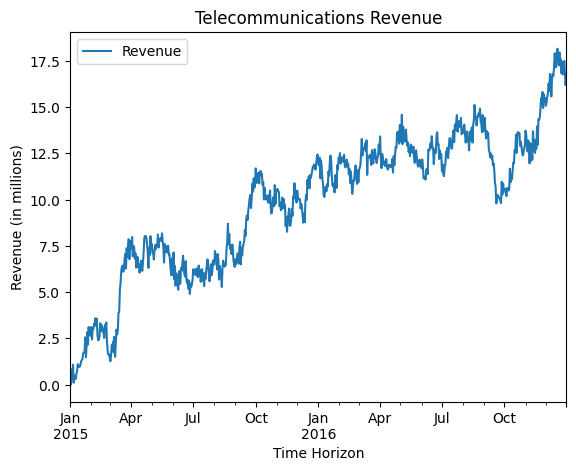

In [4]:
# Plot line graph
df = df.set_index(pd.date_range(start='2015-1-1', periods=df.shape[0], freq='D'))
df.drop('Day', axis=1, inplace=True)
df.plot(title='Telecommunications Revenue', ylabel='Revenue (in millions)', xlabel='Time Horizon')

<AxesSubplot:>

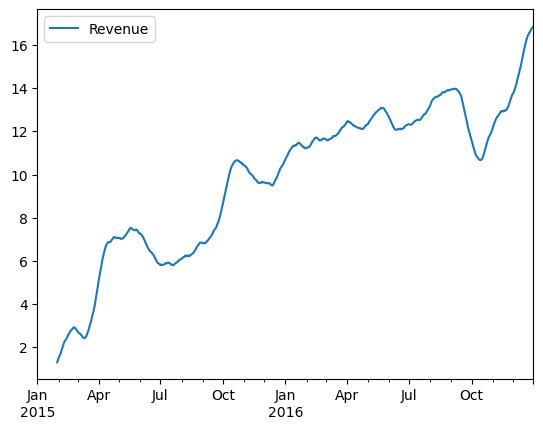

In [5]:
# Plot the rolling mean 
df.rolling(window = 30).mean().plot()

In [6]:
# Evalute the stationarity using Augmented Dickey-Fuller
adf_test = adfuller(df, autolag='AIC')
results = pd.DataFrame(adf_test[:4], columns=['Results '], dtype=object)
results.index=['Test Statistic', 'p-value', 'Num Lags', 'Num Observations']
print('Results of Augmented Dickey-Fuller Test for Revenue:\n\n', results)

Results of Augmented Dickey-Fuller Test for Revenue:

                   Results 
Test Statistic   -1.924612
p-value           0.320573
Num Lags               1.0
Num Observations     729.0


<AxesSubplot:title={'center':'Differenced (Daily) Telecommunications Revenue'}, ylabel='Revenue (in millions)'>

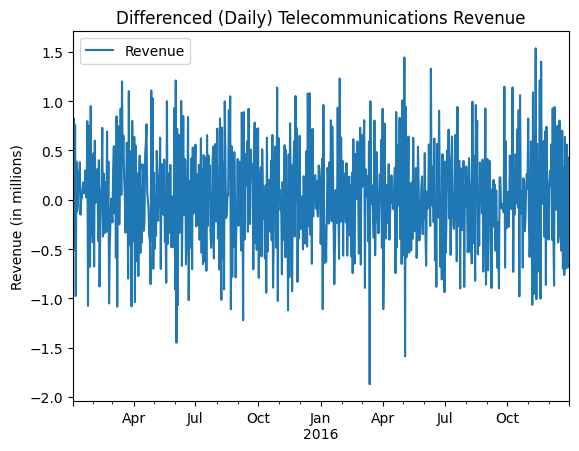

In [7]:
# Difference the time series and plot
df_diff = df.diff().dropna()
df_diff.plot(title = 'Differenced (Daily) Telecommunications Revenue', ylabel='Revenue (in millions)')

<AxesSubplot:>

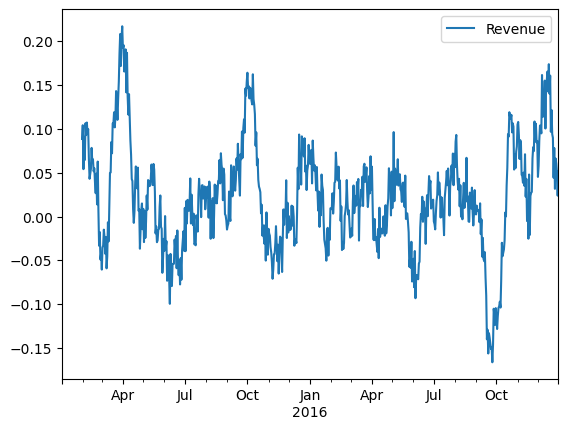

In [8]:
# Plot differenced rolling mean 
df_diff.rolling(window = 30).mean().plot()

In [9]:
# Evaluate stationarity of differenced revenue
adf_diff_test = adfuller(df_diff, autolag='AIC')
results = pd.DataFrame(adf_diff_test[:4], columns=['Results '], dtype=object)
results.index=['Test Statistic', 'p-value', 'Num Lags', 'Num Observations']
print('Results of Augmented Dickey-Fuller Test for Differenced Revenue:\n\n', results)

Results of Augmented Dickey-Fuller Test for Differenced Revenue:

                    Results 
Test Statistic   -44.874527
p-value                 0.0
Num Lags                0.0
Num Observations      729.0


In [10]:
# Train/Test split
train, test = train_test_split(df_diff, test_size = .2, shuffle = False, random_state = 123)
train

,Revenue
2015-01-02,0.000793
2015-01-03,0.824749
2015-01-04,-0.505210
2015-01-05,0.762222
2015-01-06,-0.974900
...,...
2016-08-03,0.113264
2016-08-04,-0.531705
2016-08-05,-0.437835
2016-08-06,0.422243


In [11]:
test

,Revenue
2016-08-08,-0.531923
2016-08-09,0.157387
2016-08-10,-0.644689
2016-08-11,0.995057
2016-08-12,-0.438775
...,...
2016-12-27,0.170280
2016-12-28,0.559108
2016-12-29,-0.687028
2016-12-30,-0.608824


In [12]:
# Save training and testing sets to CSV
train.to_csv('D213_task1_train_clean.csv')
test.to_csv('D213_task1_test_clean.csv')

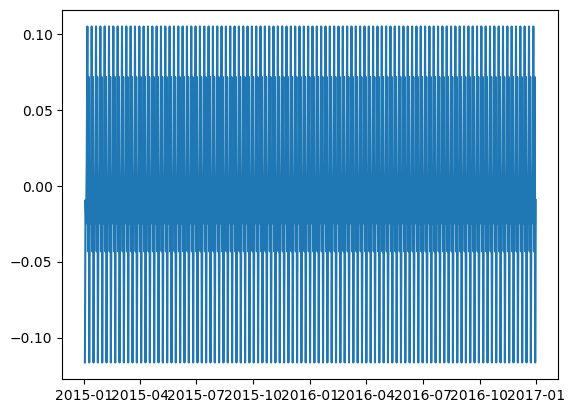

In [13]:
# Decompose differenced revenue
decomposed_df_diff = seasonal_decompose(df_diff)
plt.plot(decomposed_df_diff.seasonal)

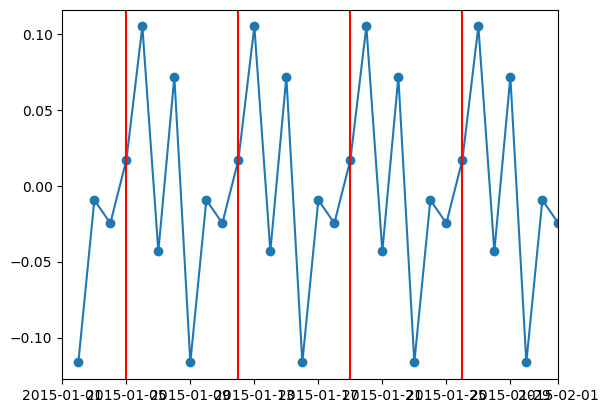

In [14]:
# Plot seasonal component
plt.plot(decomposed_df_diff.seasonal, marker = 'o')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2015-02-01'))

# Draw red lines at the start of the week
plt.axvline(x=pd.to_datetime('2015-01-05'), color='red')
plt.axvline(x=pd.to_datetime('2015-01-12'), color='red')
plt.axvline(x=pd.to_datetime('2015-01-19'), color='red')
plt.axvline(x=pd.to_datetime('2015-01-26'), color='red')

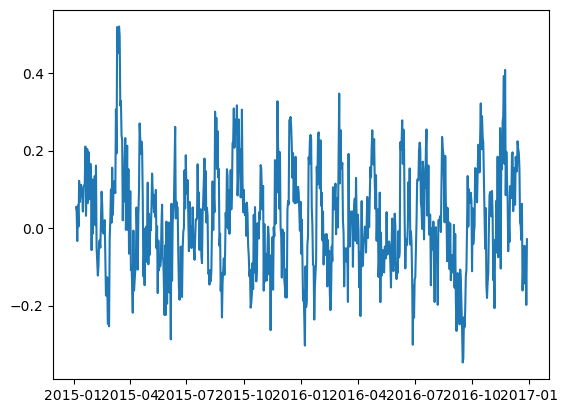

In [15]:
# Plot trend
plt.plot(decomposed_df_diff.trend)

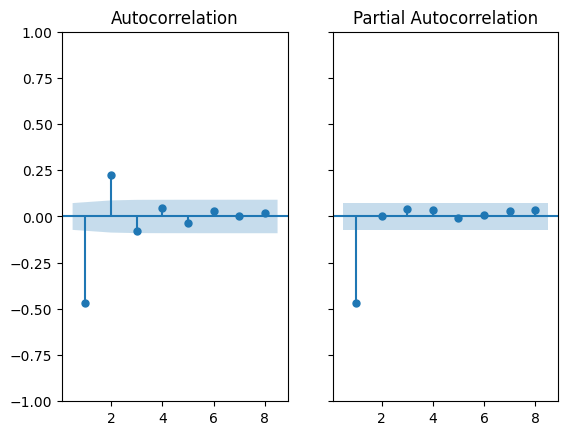

In [16]:
# Plot Autocorrelation and Partial Autocorrelation
fig, (plot1, plot2) = plt.subplots(1, 2, sharey = True)
plot_acf(df_diff, lags = 8, zero = False, ax = plot1)
plot_pacf(df_diff, lags = 8, zero = False, ax = plot2);

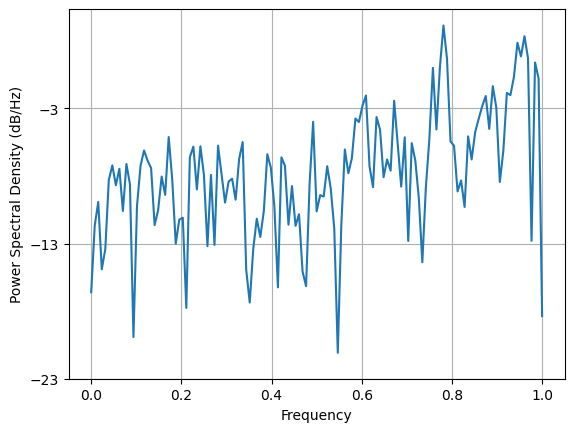

In [17]:
# Plot spectral density
plt.psd(x = df_diff['Revenue']);

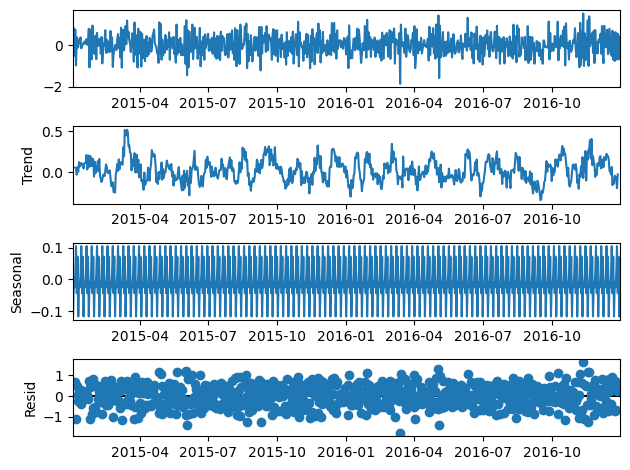

In [18]:
# Plot decomposed time series
decomposed_df_diff.plot();

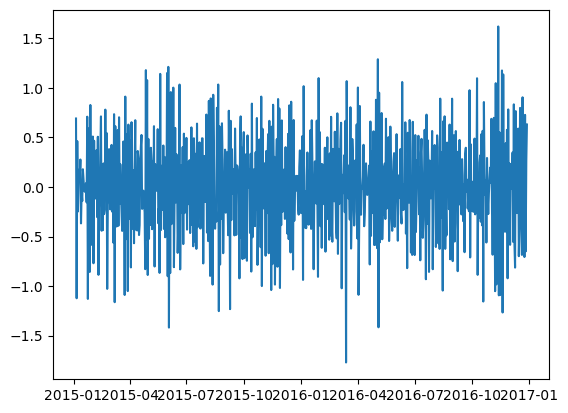

In [19]:
# Plot residual component 
plt.plot(decomposed_df_diff.resid);

In [20]:
# ARIMA model
model = ARIMA(train, order = (1,0,0), freq = 'D')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Tue, 29 Aug 2023   AIC                            773.893
Time:                        21:32:31   BIC                            787.002
Sample:                    01-02-2015   HQIC                           779.002
                         - 08-07-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

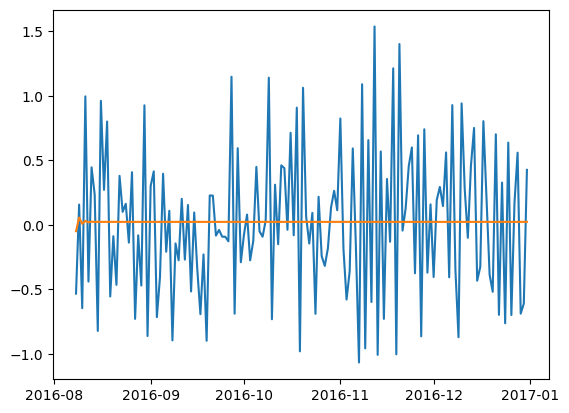

In [21]:
# Forcast 
forcast = results.get_prediction(start = 584, end = 729, dynamic = True)
plt.plot(test)
plt.plot(forcast.predicted_mean);

In [22]:
print(forcast.predicted_mean)

2016-08-08   -0.048621
2016-08-09    0.056441
2016-08-10    0.008147
2016-08-11    0.030347
2016-08-12    0.020142
                ...   
2016-12-27    0.023356
2016-12-28    0.023356
2016-12-29    0.023356
2016-12-30    0.023356
2016-12-31    0.023356
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


In [23]:
# Make dataframe out of forcast results
forcast_df = pd.DataFrame(forcast.predicted_mean)
forcast_df.rename(columns = {'predicted_mean' : 'Revenue'}, inplace = True)
forcast_df

,Revenue
2016-08-08,-0.048621
2016-08-09,0.056441
2016-08-10,0.008147
2016-08-11,0.030347
2016-08-12,0.020142
...,...
2016-12-27,0.023356
2016-12-28,0.023356
2016-12-29,0.023356
2016-12-30,0.023356


In [24]:
# Concat a copy of trainng dataset and copy of forcasted values
train_forcast_df = pd.concat([train.copy(), forcast_df.copy()])

In [25]:
# Invert differences of daily revenue
train_forcast_df = train_forcast_df.cumsum()
train_forcast_df

,Revenue
2015-01-02,0.000793
2015-01-03,0.825542
2015-01-04,0.320332
2015-01-05,1.082554
2015-01-06,0.107654
...,...
2016-12-27,16.952019
2016-12-28,16.975375
2016-12-29,16.998730
2016-12-30,17.022086


In [26]:
# Calculate confidence intervals
conf_int = forcast.conf_int()
conf_int

,lower Revenue,upper Revenue
2016-08-08,-0.963665,0.866422
2016-08-09,-0.950645,1.063528
2016-08-10,-1.017331,1.033625
2016-08-11,-0.998976,1.059669
2016-08-12,-1.009990,1.050275
...,...,...
2016-12-27,-1.006994,1.053705
2016-12-28,-1.006994,1.053705
2016-12-29,-1.006994,1.053705
2016-12-30,-1.006994,1.053705


In [27]:
# Establish dataframe baseline for confidence intervals based on last row of untransformed training set
baseline = pd.DataFrame({'lower Revenue' : [df['Revenue'][583]], 'upper Revenue' : [df['Revenue'][583]], 'date' : ['2016-08-07']})
baseline['date'] = pd.to_datetime(baseline['date'])
baseline.set_index('date', inplace = True)
baseline

,lower Revenue,upper Revenue
date,,
2016-08-07,13.504886,13.504886


In [28]:
# Concat the baseline and confidence intervals 
conf_int = pd.concat([baseline, conf_int])
conf_int = conf_int.cumsum()
conf_int = conf_int.loc['2016-08-08' : '2016-12-31']
conf_int

,lower Revenue,upper Revenue
2016-08-08,12.541221,14.371307
2016-08-09,11.590576,15.434835
2016-08-10,10.573245,16.468460
2016-08-11,9.574270,17.528129
2016-08-12,8.564279,18.578404
...,...,...
2016-12-27,-129.392812,162.936970
2016-12-28,-130.399806,163.990675
2016-12-29,-131.406800,165.044381
2016-12-30,-132.413794,166.098086


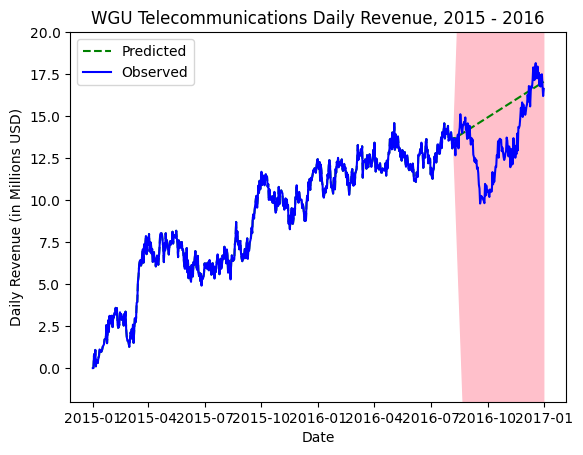

In [29]:
# Graph predicted and observed data
plt.title("WGU Telecommunications Daily Revenue, 2015 - 2016")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (in Millions USD)")
plt.plot(train_forcast_df, color = 'green', linestyle = 'dashed')
plt.plot(df, color = 'blue')
plt.fill_between(conf_int.index, conf_int['lower Revenue'], conf_int['upper Revenue'], color = 'pink')
plt.ylim(-2, 20)
plt.legend(['Predicted', 'Observed'])
plt.show()

In [30]:
# Calculate root mean squared error of forecasted vs observed (untransformed)
rmse = mean_squared_error(df.loc['2016-08-08' : '2016-12-31'], train_forcast_df.Revenue.loc['2016-08-08' : '2016-12-31'], squared=False)
print(f"The root mean squared error of this forecasting model is {round(rmse, 5)}")

The root mean squared error of this forecasting model is 2.47394


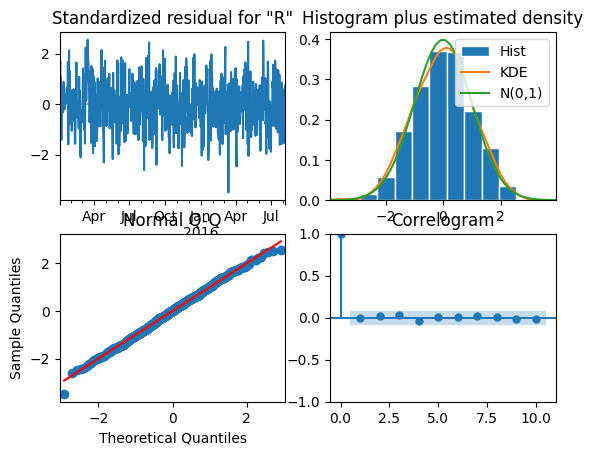

In [31]:
# Plot diagnostics
results.plot_diagnostics();